In [1]:
# --- 1. Imports ---
from ultralytics import YOLO
from paddleocr import PaddleOCR
import re
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import easyocr
import numpy as np

# --- 2. Cargar modelo YOLO ---
model = YOLO("/home/gnz/GitHub/yolo11_container/runs/detect/train2/weights/best.pt")

# --- 3. Inicializar EasyOCR ---
# reader = easyocr.Reader(['en','es'])  # podés agregar ['en', 'es'] si querés español
# PaddleOCR inicializado (puedes ajustar lang si necesitas chino, inglés, etc.)
ocr_model = PaddleOCR(use_textline_orientation=True, lang="en")


/home/gnz/GitHub/yolo11_container/.venv/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)


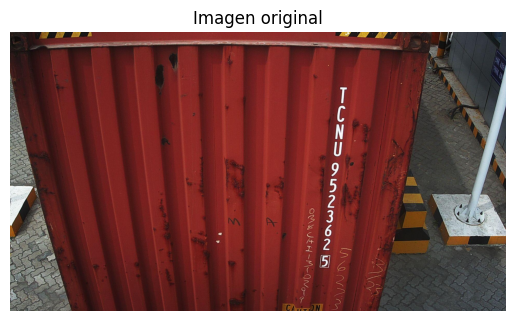

In [6]:
# --- 4. Cargar imagen de prueba ---
image_path = "/home/gnz/GitHub/yolo11_container/images/1-123554001-OCR-AH-A01_jpg.rf.5dec9c2205179b3fc4fcbbafccad3e38.jpg"   # poné acá tu imagen de contenedor
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convertir a RGB
plt.imshow(image)
plt.title("Imagen original")
plt.axis("off")
plt.show()


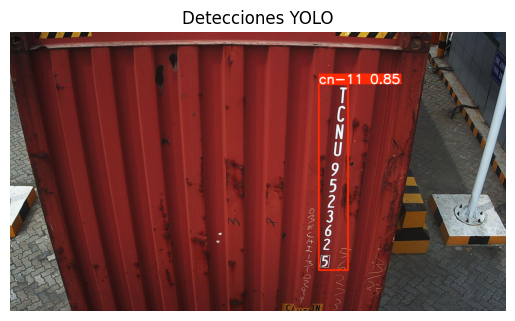

In [7]:
# --- 5. Inferencia con YOLO ---
results = model.predict(image, conf=0.25, verbose=False)
annotated = results[0].plot()  # imagen con bounding boxes dibujados

plt.imshow(annotated)
plt.title("Detecciones YOLO")
plt.axis("off")
plt.show()

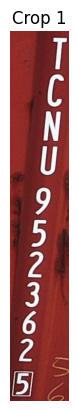

In [8]:
# --- 6. Generar crops de cada bounding box ---
crops = []
for i, box in enumerate(results[0].boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    crop = image[y1:y2, x1:x2]
    crops.append(crop)
    
    plt.imshow(crop)
    plt.title(f"Crop {i+1}")
    plt.axis("off")
    plt.show()


[Crop 1] Texto detectado: n a o t o e e e e e e e i e e


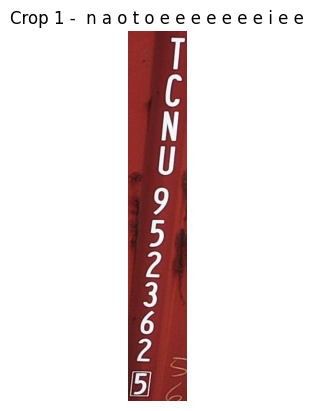

In [9]:
# --- 7. OCR sobre cada crop ---
for i, crop in enumerate(crops):
    # PaddleOCR espera imágenes en formato RGB
    ocr_result = ocr_model.predict(crop)
    if ocr_result and len(ocr_result[0]) > 0:
        text = " ".join([res[1][0] for res in ocr_result[0]])
    else:
        text = "(sin texto detectado)"

    print(f"[Crop {i+1}] Texto detectado: {text}")

    plt.imshow(crop)
    plt.title(f"Crop {i+1} -  {text}")
    plt.axis("off")
    plt.show()


In [ ]:

# --- 1. Cargar modelo YOLO de caracteres ---
# (este deberías entrenarlo con bounding boxes de letras/números)
# char_model = YOLO("char_detector.pt")

# --- 2. Recorrer los crops detectados en el primer modelo ---
ordered_codes = []

for i, box in enumerate(results[0].boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    crop = image[y1:y2, x1:x2]

    # Verificamos si el crop parece "vertical"
    h, w = crop.shape[:2]
    is_vertical = h > 2 * w   # heurística simple, la podés ajustar
    
    if is_vertical or box.cls in [cn4_class_id, cn7_class_id]:
        # --- 3. Pasar el crop por el modelo de caracteres ---
        char_results = char_model(crop)

        chars = []
        for cbox in char_results[0].boxes:
            cx1, cy1, cx2, cy2 = map(int, cbox.xyxy[0].tolist())
            char_crop = crop[cy1:cy2, cx1:cx2]

            # (Opcional) aplicar OCR a cada caracter
            # Por simplicidad, si entrenás YOLO para clasificar dígito/letra,
            # podrías extraer directamente cbox.cls → que sería el caracter.
            char_label = char_model.names[int(cbox.cls)]
            chars.append((cy1, char_label))  # usamos cy1 para ordenar

        # --- 4. Ordenar caracteres por posición vertical (top to bottom) ---
        chars = sorted(chars, key=lambda x: x[0])

        # --- 5. Concatenar en un string ---
        code = "".join([c[1] for c in chars])
        ordered_codes.append(code)

        # Visualización rápida
        print(f"Crop {i+1} → {code}")
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Reconstruido: {code}")
        plt.axis("off")
        plt.show()

    else:
        # Si es horizontal → mandar directo a OCR normal
        ordered_codes.append("OCR_Horizontal")
